In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Clustering de voitures

Nous souhaitons diviser des voitures en plusieurs groupes. Commençons par regarder les données : 

In [1]:

data = pd.read_excel("voitures_clustering.xlsx")
data

,Modele,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,PANDA,54,1108,150,354,159,154,860,135
1,TWINGO,60,1149,151,344,163,143,840,143
2,YARIS,65,998,155,364,166,150,880,134
3,CITRONC2,61,1124,158,367,166,147,932,141
4,CORSA,70,1248,165,384,165,144,1035,127
5,FIESTA,68,1399,164,392,168,144,1138,117
6,CLIO,100,1461,185,382,164,142,980,113
7,P1007,75,1360,165,374,169,161,1181,153
8,MODUS,113,1598,188,380,170,159,1170,163
9,MUSA,100,1910,179,399,170,169,1275,146


L'histogramme de chaque paramètre donne des indications sur sa répartition :

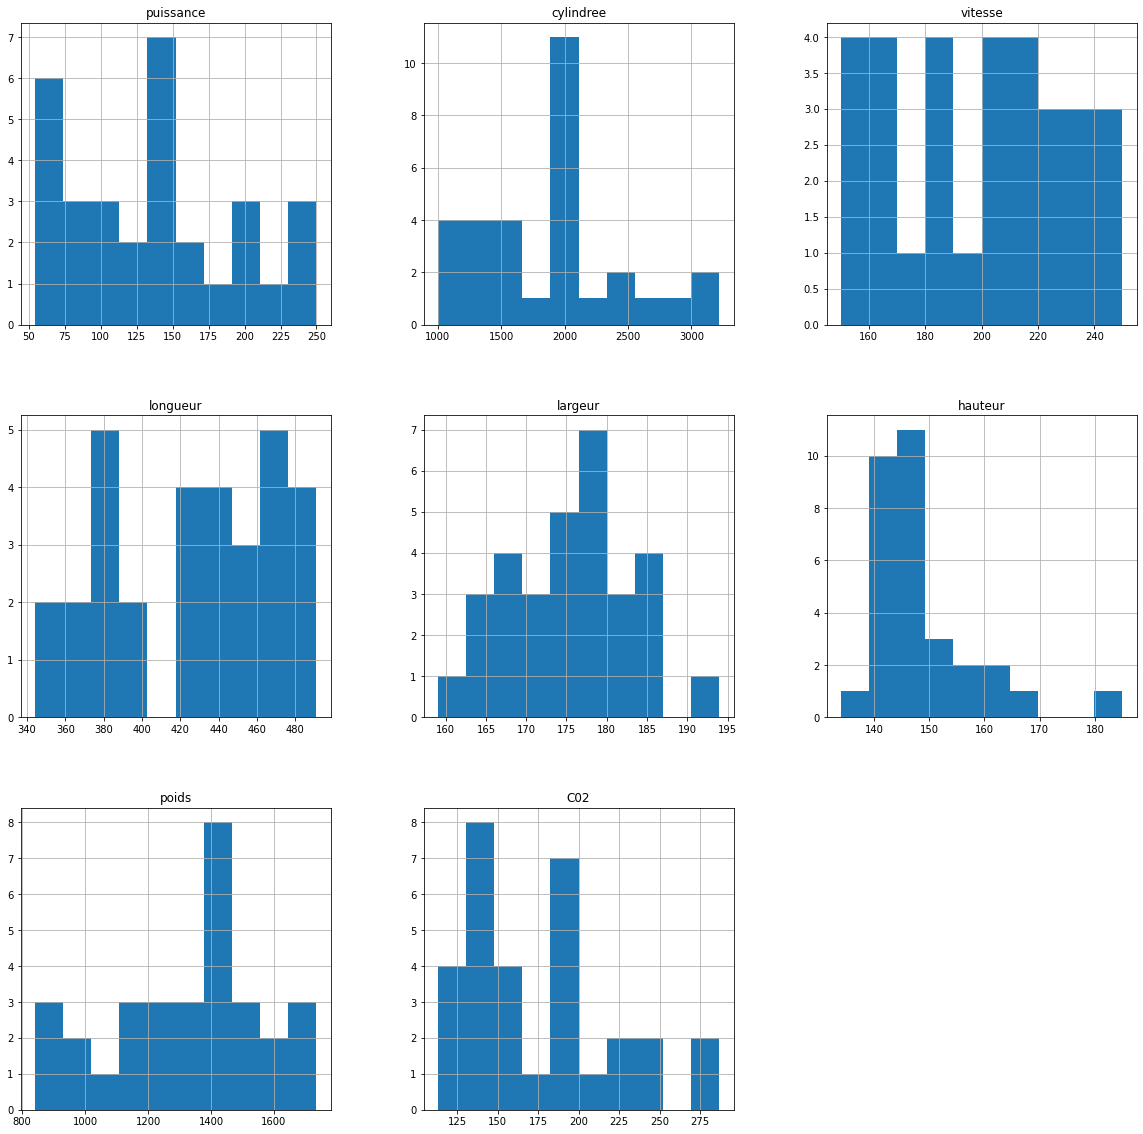

In [2]:
data.hist(bins=10, figsize=(20, 20));

Pour utiliser un algorithme de machine learning, il est toujours conseillé de standardiser les données.

In [3]:
from sklearn import preprocessing

data_scaled = preprocessing.scale(data.iloc[:, 1:])  # standardisation

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data2d = pd.DataFrame(pca.fit_transform(data_scaled), index=data["Modele"], columns=["x", "y"])
pca.explained_variance_ratio_ # variance expliquée par les deux axes principaux

array([0.68538152, 0.164953  ])

In [5]:
pd.DataFrame(pca.components_, index=["x", "y"], columns=data.columns[1:])  # coordonnées des deux axes principaux

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
x,-0.395955,-0.371059,-0.406241,-0.386756,-0.338006,0.100741,-0.38471,-0.344273
y,-0.217416,0.063236,-0.113148,0.183883,0.350161,0.757701,0.29559,-0.343538


On voit que l'axe x discrimine les grosses voitures : plus cette valeur est petite, plus la voiture correspondante est puissante, rapide, large, polluante... Étonnamment, la hauteur rentre peu en compte sur cet axe et est même inversement proportionnelle aux autre coordonnées.  
L'axe y discrimine les voitures selon leur hauteur principalement.  
Il y a donc 2 informations particulièrement importantes : la largeur générale de la voiture et sa hauteur.  

In [6]:
import plotly.express as px
fig = px.scatter(x=data2d.iloc[:, 0], y=data2d.iloc[:, 1], text=data2d.index)
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    width=1200,
    title_text='Données suivant les deux composantes principales du PCA'
)
fig.show()

Puisque nous ne connaissons pas à l'avance les labels/groupes, nous allons utiliser un algorithme de clustering. L'un des plus connus est K-Means. Comme K-Means dépend largement de la position des centroïdes initiaux, nous l'exécutons plusieurs fois en conservant le meilleur (i.e. avec l'inertie la plus faible) :  

In [7]:
def kmeans_multiple(data, k, n):
    km_best = KMeans(n_clusters=k).fit(data)
    for _ in range(n - 1):
        km = KMeans(n_clusters=k).fit(data)
        if km.inertia_ < km_best.inertia_:
            km_best = km
    return km_best

Pour choisir le nombre de clusters $k$, on peut dessiner l'inertie en fonction du nombre de clusters.

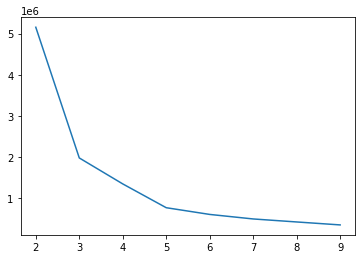

In [10]:
from sklearn.cluster import KMeans

X, Y = [], []
for k in range(2, 10):
    km = kmeans_multiple(data.iloc[:, 1:], k, 20)
    Y.append(km.inertia_)
    X.append(k)
plt.plot(X, Y);

On choisit $k$ comme le nombre de clusters à partir duquel l'inertie stagne (*elbow method*), ici 5 (on pourrait aussi raisonnablement choisir 3).

In [16]:
km = kmeans_multiple(data.iloc[:, 1:], 5, 20)

In [17]:
import plotly.express as px
fig = px.scatter(x=data2d.iloc[:, 0], y=data2d.iloc[:, 1], text=data2d.index, color=list(map(str, km.labels_)))
fig.update_traces(marker=dict(size=12), textposition='top center')
fig.update_layout(height=600, width=1200, title_text='Données suivant les deux composantes principales du PCA')
fig.show()


In [18]:
data.groupby(km.labels_) \
    .mean()

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,62.000000,1125.400000,155.800000,362.60,163.800000,147.600000,909.400000,136.000000
1,138.250000,1961.750000,206.500000,441.25,178.333333,148.333333,1368.250000,171.916667
2,228.333333,3126.666667,247.666667,470.00,181.000000,144.666667,1546.666667,233.666667
3,109.142857,1460.142857,186.857143,406.00,172.857143,152.571429,1223.428571,159.714286
4,196.750000,2458.500000,215.000000,470.25,179.750000,151.250000,1660.500000,221.000000


Ainsi on distingue :  
- Groupe 0 : citadines. Peu puissante, petite, légère, faible consommation. Exemple : Twingo.
- Groupe 1 : voitures "normales". Exemple : Laguna.
- Groupe 2 : voitures sportives. Puissante, rapide, polluante, plutôt basse. Exemple : BMW530
- Groupe 3 : voitures familiales. Haute, peu rapide. Exemple : Berlingo.
- Groupe 4 : SUV. Lourde, polluante, puissante. Exemple : C5.

In [22]:
from sklearn.linear_model import LogisticRegression

rows = []
for i in range(km.n_clusters):
    t = np.where(km.labels_ == i)[0]
    y = np.zeros((len(data.index)))
    y[t] = 1
    lr = LogisticRegression(max_iter = 4000).fit(data.iloc[:, 1:], y)
    rows.append(lr.coef_[0])

pd.DataFrame(rows, columns=data.columns[1:])

,puissance,cylindree,vitesse,longueur,largeur,hauteur,poids,C02
0,-0.087781,-0.053437,0.050838,0.209210,0.098439,0.090459,-0.041854,0.024228
1,-0.075231,0.000011,0.132013,-0.014546,-0.017081,-0.092754,0.005461,-0.005305
2,0.006403,0.035035,-0.003779,-0.029372,-0.014005,-0.013109,-0.048291,-0.013247
3,-0.081252,-0.011667,0.212475,-0.076696,0.018382,-0.041133,0.019609,-0.019152
4,-0.041193,0.002007,-0.412978,0.020095,-0.274442,-0.009265,0.059024,0.205293
